# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab/'
path.append(root)

amazon_en_label = 'amazon_en'
amazon_de_label = 'amazon_de'
organic_label = 'organic'

data_location = 'data/data-with-embeddings/not-contextualized-embeddings/BERT-base-uncased/'
embedding_dim = 768

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def read_data(label, splits):
  if label is None:
    return None

  for split in splits:
    path = root + data_location + label + f'_{split}.json'
    with open(path) as json_file:      
        data_df = json_file.read() 
        data_df = json.loads(data_df)
        yield pd.DataFrame(data_df)

In [5]:
amazon_en_train_df, amazon_en_test_df = read_data(amazon_en_label,
                                                  ['train', 'test'])

In [6]:
organic_train_df, organic_test_df = read_data(organic_label, ['train', 'test'])

In [8]:
def drop(df, column, value):
  print(f'----> size before {len(df)}')
  idx = df[column] != value
  print(f'----> size after {idx.sum()}')
  return df[idx]

drop_neutral = True

if drop_neutral:
  print('======DROPPING NEUTRAL CLASS======')
  print('amazon_en: train')
  amazon_en_train_df = drop(amazon_en_train_df, 'comment_sentiment', '0')
  print('amazon_en: test')
  amazon_en_test_df = drop(amazon_en_test_df, 'comment_sentiment', '0')
  print('organic: train')
  organic_train_df = drop(organic_train_df, 'sentence_sentiment', '0')
  print('organic: test')
  organic_test_df = drop(organic_test_df, 'sentence_sentiment', '0')

======DROPPING NEUTRAL CLASS======
amazon_en: train
----> size before 98130
----> size after 98130
amazon_en: test
----> size before 17334
----> size after 17334
organic: train
----> size before 4321
----> size after 2636
organic: test
----> size before 763
----> size after 475


In [11]:
if drop_neutral:
  sentiment_classes = {'n': 0, 'p': 1}
  sentiment_labels = {0 : 'n', 1 : 'p'} 
else:
  sentiment_classes = {'n': 0, '0': 1, 'p': 2}
  sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'} 

last_column = str(embedding_dim - 1)

def parse_amazon_data(df, downsampling_factor=1):
  if df is None:
    return dataset.DocumentDataset((), ()), ()

  comments = []
  sentiments = []

  for comment_id, comment_df in df.groupby('comment_id'):
    nunique_sentiments = comment_df['comment_sentiment'].nunique()
    if (nunique_sentiments > 1):
      print('Found inconsitent sentiment'
            f'for the comment with id = {comment_id}')

    sentiment = comment_df['comment_sentiment'][0]
    if sentiment == 'p' and random.random() > downsampling_factor:
      continue

    comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
    sentiments.append(sentiment_classes[sentiment])

  sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
  sentiments = torch.Tensor(sentiments).to(device)

  return sentiment_dataset, sentiments

In [12]:
amazon_en_dataset, amazon_en_sentiments = parse_amazon_data(amazon_en_train_df,
                                                            0.15)
amazon_en_test_dataset_ds, amazon_en_test_sentiments_ds = parse_amazon_data(
    amazon_en_test_df, 0.15)
amazon_en_test_dataset, amazon_en_test_sentiments = parse_amazon_data(
    amazon_en_test_df)

NameError: ignored

In [13]:
def parse_organic_data(df):
  embeddings = torch.Tensor(df.loc[:, '0':last_column].values).to(device)
  sentiments = torch.Tensor(df['sentence_sentiment'].apply(
      lambda sentiment: sentiment_classes[sentiment])).to(device)
  out_dataset = dataset.DocumentDataset(tuple(embeddings.unsqueeze(1)),
                                        sentiments)
  return out_dataset

In [14]:
organic_dataset = parse_organic_data(organic_train_df)
organic_test_dataset = parse_organic_data(organic_test_df)

In [15]:
datasets = {amazon_en_label: amazon_en_dataset, organic_label: organic_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(amazon_en) = 3258
len(organic) = 2636


In [16]:
full_stats = amazon_en_train_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
sentiments, counts = amazon_en_sentiments.unique(return_counts=True, sorted=True)
for sentiment, count in zip(sentiments, counts):
  label = sentiment_labels[sentiment.item()]
  print(f'sentiment "{label}":')
  print(f'\tbefore downsampling -> {full_stats[label]}; '
        f'after downsampling -> {count.item()}')

sentiment "n":
	before downsampling -> 1370; after downsampling -> 1370
sentiment "p":
	before downsampling -> 12519; after downsampling -> 1888


In [17]:
def split(dataset_to_split, splits=(0.824, 0.176)):
  assert(sum(splits) == 1)
  n_comments = len(dataset_to_split)
  n_val = int(splits[1] * n_comments)
  n_train = n_comments - n_val

  return utils.data.random_split(dataset_to_split, (n_train, n_val))

amazon_en_train, amazon_en_val = split(amazon_en_dataset)
organic_train, organic_val = split(organic_dataset)

In [19]:
def train(milnet, train_set, val_set, batch_size, optim_params, fit_params):
  train_loader = utils.data.DataLoader(train_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(milnet.parameters(), **optim_params)
  criterion = nn.NLLLoss()

  return trainer.fit(milnet, optimizer, criterion, dataloaders, **fit_params)

In [20]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.5
params.dropout_att = 0.5
params.dropout_seg = 0.5
params.classes_nb = 3 - drop_neutral

In [21]:
optim_params = {'lr': 5e-3, 'weight_decay': 1e-2}
fit_params = {'nb_epochs': 300, 'patience': 80, 'print_every': 15}

milnet = model.MilNet(params, train_embeddings=False).to(device)

print("=====TRAIN ON AMAZON DATA=====")
_, amazon_train_losses, amazon_val_losses = train(milnet, amazon_en_train,
                                                  amazon_en_val,
                                                  batch_size=128,
                                                  optim_params=optim_params,
                                                  fit_params=fit_params)

torch.save(milnet.state_dict(),
           root + f'/models/milnet/state_dicts/bert_base_no_finetune_{params.classes_nb}cl')

print("=====FINETUNE ON ORGANIC DATA=====")
_, organic_train_losses, organic_val_losses = train(milnet, organic_train,
                                                    organic_val,
                                                    batch_size=128,
                                                    optim_params=optim_params,
                                                    fit_params=fit_params)
torch.save(milnet.state_dict(),
           root + f'/models/milnet/state_dicts/bert_base_{params.classes_nb}cl')

=====TRAIN ON AMAZON DATA=====
Epoch  15/300 -> train loss: 3.69e-03, accuracy: 75.87%
Epoch  15/300 -> val loss: 3.07e-03, accuracy: 73.47%
Epoch  30/300 -> train loss: 3.69e-03, accuracy: 74.64%
Epoch  30/300 -> val loss: 3.02e-03, accuracy: 74.17%
Epoch  45/300 -> train loss: 3.63e-03, accuracy: 76.69%
Epoch  45/300 -> val loss: 3.02e-03, accuracy: 73.47%
Epoch  60/300 -> train loss: 3.63e-03, accuracy: 74.97%
Epoch  60/300 -> val loss: 3.02e-03, accuracy: 72.77%
Epoch  75/300 -> train loss: 3.58e-03, accuracy: 76.80%
Epoch  75/300 -> val loss: 2.92e-03, accuracy: 76.79%
Epoch  90/300 -> train loss: 3.62e-03, accuracy: 76.87%
Epoch  90/300 -> val loss: 2.96e-03, accuracy: 73.82%
Epoch 105/300 -> train loss: 3.72e-03, accuracy: 74.49%
Epoch 105/300 -> val loss: 2.90e-03, accuracy: 75.74%
Epoch 120/300 -> train loss: 3.59e-03, accuracy: 76.76%
Epoch 120/300 -> val loss: 3.03e-03, accuracy: 74.17%
Epoch 135/300 -> train loss: 3.58e-03, accuracy: 76.83%
Epoch 135/300 -> val loss: 2.96e-

KeyboardInterrupt: ignored

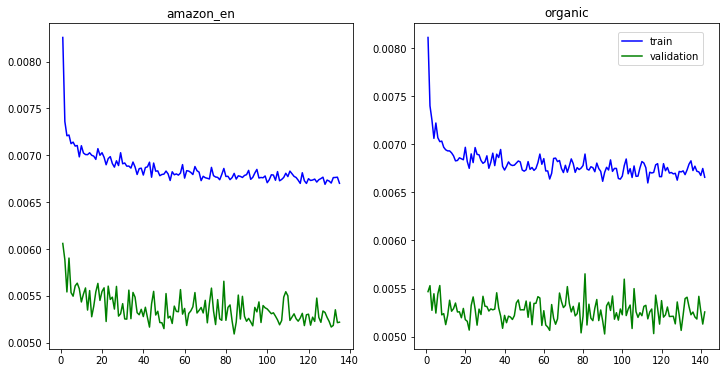

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon_en, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon_en, amazon_en_train_losses,
            amazon_en_val_losses)
plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [ ]:
# torch.save(milnet.state_dict(), root + '/models/milnet/state_dicts/base_bert')
milnet.load_state_dict(torch.load(root + '/models/milnet/state_dicts/base_bert'))

<All keys matched successfully>

In [ ]:
def get_results(test_set):
  test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  for documents, classes in test_loader:
    predictions = milnet(documents).cpu().numpy()
    return (np.argmax(predictions, axis=1), classes.cpu().numpy())

AMAZON_EN = 'amazon_en'
AMAZON_DE = 'amazon_de'
ORGANIC = 'organic'
results = {}


milnet.eval()
with torch.set_grad_enabled(False):
  results[AMAZON_EN] = get_results(amazon_en_test)
  results[ORGANIC] = get_results(organic_test)
  if amazon_de_df is not None:
    results[GERMAN_DE] = get_results(amazon_de_dataset)

In [ ]:
for dataset_name, (top1, labels) in results.items():
  print(f'=== {dataset_name} ===')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon_en ===
F1-micro = 0.5137420718816068
F1-macro = 0.42942388314039004

         n    0    p
    n   71   14   54
    0   37   10   99
    p   21    5  162

=== organic ===
F1-micro = 0.594488188976378
F1-macro = 0.5949820243423923

         n    0    p
    n   87   38   21
    0   49  118   32
    p   19   47   97



In [14]:
from sklearn.model_selection import train_test_split
def split(full_set, label):
  train, test = train_test_split(full_set, test_size=0.15)
  train.to_json(root + data_location + label + f'_train.json')
  test.to_json(root + data_location + label + f'_test.json')

split(amazon_en_df, amazon_en_label)
split(organic_df, organic_label)